# Ансамблевые алгоритмы машинного обучения

# Качество простых алгоритмов

Простые алгоритмы, которые мы изучали раньше, зачастую дают не очень хороший прогноз предсказаний. Попробуем применить простые алгоритмы для решения одной из известных задач.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Предобработаем данные для логистической регрессии
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)

X_scaled = StandardScaler().fit_transform(X) # Поправить

X_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, shuffle=True, random_state=1917
)


In [ ]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
knn_clf = KNeighborsClassifier().fit(X_train, y_train)
linear_clf = LogisticRegression().fit(X_train, y_train)

In [ ]:
predictions_tree = tree_clf.predict(x_test)
predictions_knn = knn_clf.predict(x_test)
predictions_linear = linear_clf.predict(x_test)

In [ ]:
accuracy_tree = accuracy_score(predictions_tree, y_test)
accuracy_knn = accuracy_score(predictions_knn, y_test)
accuracy_linear = accuracy_score(predictions_linear, y_test)

In [ ]:
print(f'Accuracy of tree classifier: {accuracy_tree}\nAccuracy of knn classifier: {accuracy_knn}\nAccuracy of linear classifier: {accuracy_linear}')

Accuracy of tree classifier: 0.9415204678362573
Accuracy of knn classifier: 0.9824561403508771
Accuracy of linear classifier: 0.9824561403508771


In [ ]:
(predictions_linear == predictions_knn).all()

False

Каждый из этих классификаторов неплохо классифицирует исходный датасет. А что, если провести голосование?

In [ ]:
sum_of_voices = (
    predictions_tree.astype(int)
    + predictions_knn.astype(int)
    + predictions_linear.astype(int)
)
voiting_result = (sum_of_voices > 1).astype(int)

In [ ]:
accuracy_voiting = accuracy_score(voiting_result, y_test)
print(f"Voiting result: {accuracy_voiting}")

Voiting result: 1.0


Мы получили идеальное предсказание, объединив независимые мнения трёх различных классификаторов!

Да здравствует демократия!

**Такой подход называется ансамблированием.**

# Ансамбли

Ансамбли — серьёзные модели машинного обучения. Они мощные, и позволяют отражать сложные зависимости между данными. Однако, за «силу» ансамблей приходится платить их интерпретируемостью. Такие алгоритмы часто называют «чёрными ящиками»: по ним трудно понять, какие же признаки повлияли на прогноз для конкретного наблюдения. Вам решать, чем именно вы готовы пожертвовать, решая задачу.

Идея ансамбля моделей проста. Пусть вы решили задачу бинарной классификации моделью  $m_1$  на основе дерева принятия решений. Получили значение метрики accuracy = 0.8. Однако все модели склонны переобучаться. Один алгоритм, обученный на всех наблюдениях train и всех признаках, может сильно ошибаться на валидации. Есть идея взять ещё одну модель —  $m_2$ , компенсирующую ошибки первой. Сама по себе она также может давать не очень высокий accuracy. Например, accuracy=0.79. Можно поменять условия ещё раз и построить ещё одну модель  $m_3$, и так далее до модели  $m_n$. В итоге каждая модель из $n$ будет подвержена разным случайным факторам в зависимости от своих отличий, но при этом принесёт собственное сакральное знание о наблюдениях. Можно попытаться учесть их все одновременно — получить сводную модель $M$, которая будет давать результат лучше, чем каждая в отдельности, скажем, accuracy = 0.91. Такую сводную модель будем называть **сильной** (говорят «сильным классификатором»), а модели, на основании которых она построена — **слабыми** (или «слабыми классификаторами»).

# Разложение ошибки*

Вспомним постановку задачи регрессии (аналогичные рассуждения справедливы и для классификации). Пусть есть некоторая функция $f(x)$ и нормальный шум $ϵ$, причем мы будем считать, что $ϵ$ ~ $N(0, σ^2)$. Тогда в рамках постановки задачи регрессии мы имеем набор объектов $x_i \in X$ и соответствующий им набор меток:

$$y_i = f(x_i) + ϵ$$

Пусть мы также имеем некоторую функцию $\hat{f}(x)$ - наш вариант модели регрессии. Мы вводили понятие *эмпирического риска* $Q = E_X[L(x, y)]$

Часто в задачах мы используем среднеквадратическое отклонение в качестве $Q$:
$$Q = \frac{1}{N}\sum\limits_{i=1}^N (y_i - \hat{f}(x_i))^2$$
Попробуем оценить математическое ожидание* величины квадрата отклонения предсказания от метки:

$E[(y - \hat{f}(x))^2] = E[y^2] - 2y\hat{f}(x) + (\hat{f}(x))^2] = E[y^2] + E[(\hat{f}(x))^2] - 2E[y\hat{f}(x)] = $

//С этого момента будем опускать аргумент $(x)$ в записи $\hat{f}(x)$ ради упрощения восприятия текста//

$= E[y^2] + E[\hat{f}^2] - 2E[y\hat{f}] = $

Вспомним, что дисперсию $Dy$ можно определить, как $Dy = E[y^2] - (E[y])^2$(1)


$= Dy + (E[y])^2 + D\hat{f} + (E[\hat{f}])^2 - 2fE[\hat{f}] =$

Последний переход получился при помощи применения равенства (1) к предыдущему результату, а также вынесением $f$ за знак математического ожидания в последнем слагаемом в силу того, что  $y = f + ϵ$, где $f$ - детерменированная величина, а значит может быть вынесена за знак математического ожидания, а $ϵ$ имеет нулевое матожидание. Теперь вспомним, что $y = f + ϵ$, а значит $E[y] = E[f] + E[ϵ] = E[f]$

$= Dy + D\hat{f} + (E[f]^2 + E[\hat{f}]^2 - 2fE[\hat{f}]) = Dy + D\hat{f} + (f - E[\hat{f}])^2 = σ^2 + D\hat{f} + (f - E[\hat{f}])^2$

Последний переход получился, так как $Dy = D[f + ϵ]$, где $f$ - детерменированная величина, не вносящая вклада в дисперсию. Значит, $Dy = Dϵ = σ^2$

Итак, мы получили:

$$E[(y - \hat{f}(x))^2] = σ^2 + D\hat{f} + (f - E[\hat{f}])^2$$

То есть матожидание ошибки предсказания модели раскладывается в 3 слагаемых:

* $σ^2$ - дисперсия шума в исходных данных. Чем выше дисперсия шума, тем хуже предсказательная способность модели, то есть выше матожидание её ошибки. Это происходит из-за того, что сильный шум не даёт модели качественно проанализировать выборку, сбивает её обучение.
* $D\hat{f}$ - разброс (variance). Представляет из себя меру того, насколько сильно элемент случайности, неоднородности в исходных данных, особенности конкретной выборки, гиперпараметры алгоритма и т.п. влияют на итоговый результат обучения.
*  $f - E[\hat{f}]$ - смещение (bias). Отображает систематическую ошибку алгоритма.

*Замечание: в данном случае математическое ожидание расматривается на множестве всевозможных выборок.

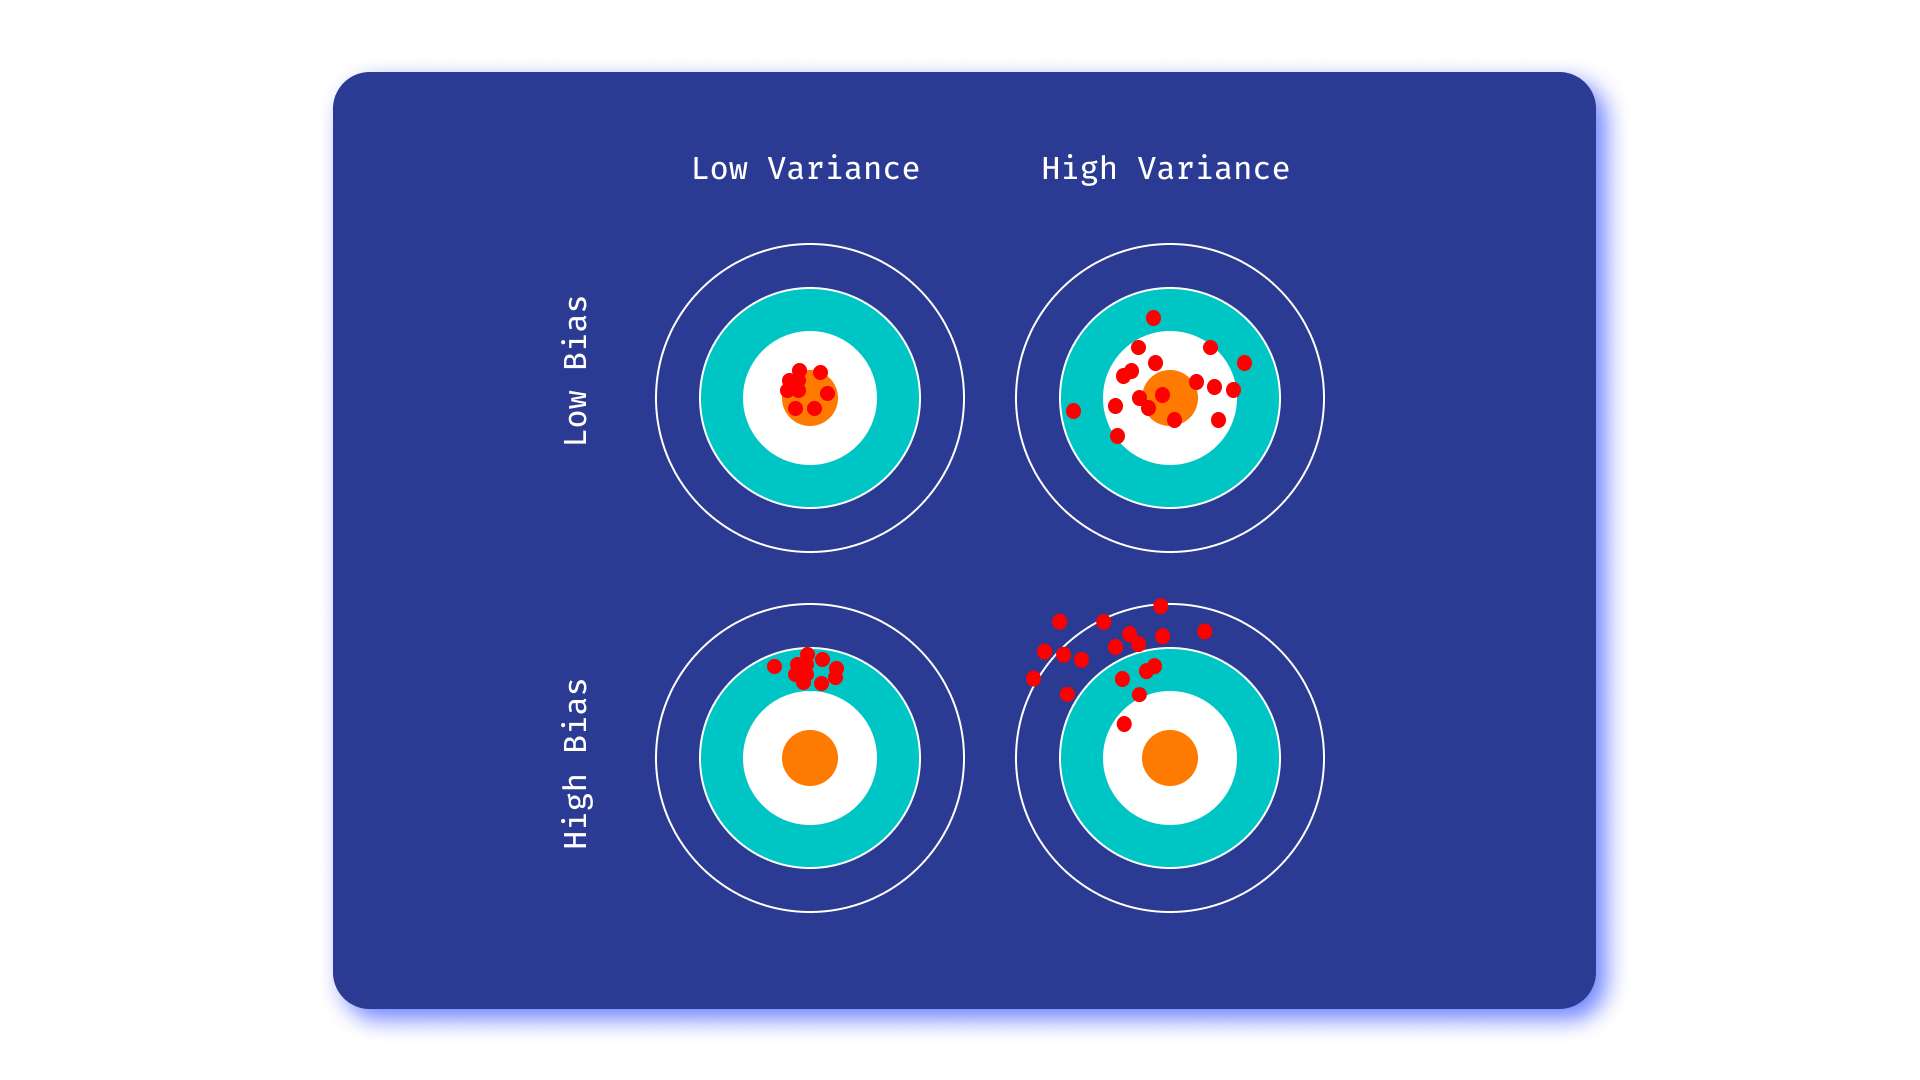

Отсюда возникает задача поиска оптимального соотношения между bias и variance. Понятно, что хотелось бы снизить оба этих показателя, но оказывается, что между ними существует определённая связь. И bias, и variance зависят от сложности выбранной модели. Усложнение модели приводит к росту разброса, а упрощение -- к росту смещения.

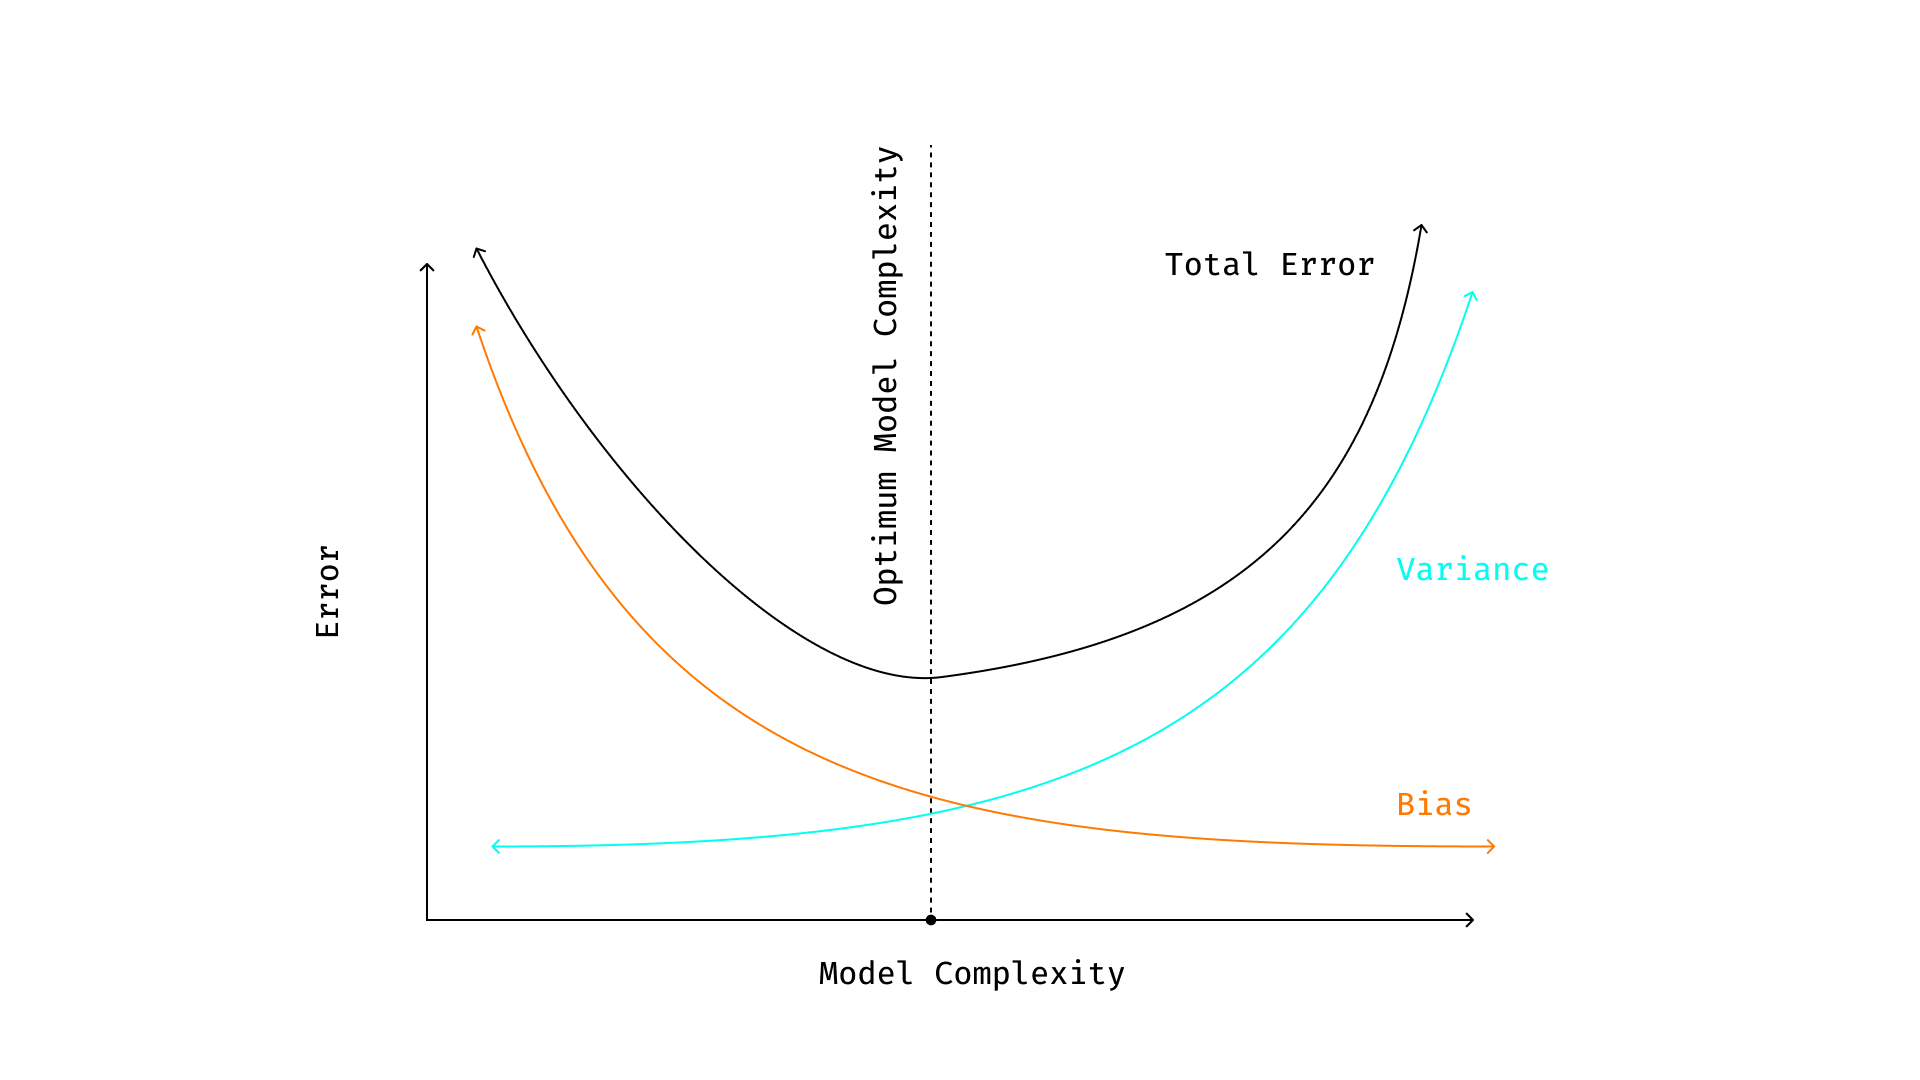

Поиск такого оптимума - это задача выбора оптимальной сложности модели, подбора гиперпараметров и т.п.

Тем не менее, оказывается, что существует довольно очевидный метод уменьшения variance при фиксированном bias. Пусть у нас есть $N$ немного отличающихся друг от друга алгоритмов одного класса. В случае, если отличия между ними действительно не очень сильные, их bias примерно одинаковый, то есть систематическая часть их ошибки близка. Пусть вместо предсказания одного из алгоритмов мы в том или ином виде будем рассматривать их совокупное предсказание. Например, усредним предсказание всех $N$ алгоритмов. Очевидно, bias такого объединенного алгоритма будет очень близок к bias каждого из исходных (базовых) алгоритмов. Variance же уменьшится, ведь мы теперь усредняем значения, случайным образом распределённые вокруг некоторой точки, что скорее всего поможет нам снизить отклонение от этой самой точки.

Таким образом, мы вновь приходим к идее ансамблирования, выразив её теперь в терминах разложения ошибки в смещение и разброс.

# Простое голосование классификаторов

Пусть у нас есть некоторое количество не очень хороших моделей. Такие модели мы будем называть *базовыми*. Обозначим их за $b_1 ... b_n$.

Пусть стоит задача бинарной классификации, то есть нужно найти алгоритм $A: X $→$ Y = {-1,1}$ (То есть метки классов обозначены за 1 и -1).

Простым голосованием классификаторов назовем следующее правило выбора итогового ответа: $$A(x) = sign(\sum\limits_{i=1}^n b_i(x))$$

Если большинство классификаторов предложили в качестве ответа +1, итоговый алгоритм также предложит в качестве ответа +1, а если большинство сошлось на варианте -1, то и итоговый ответ будет таким.

_________________
_________________
### Важное замечание

Представим, что все используемые нами классификаторы дают один и тот же ответ для каждого из объектов в выборке. Отсюда следует, что и итоговый ансамблевый алгоритм будет давать точно такие же ответы. Такой случай не даст нам абсолютно никакого преимущества по сравнению с использованием любого из базовых классификаторов.

Отсюда следует важный вывод: модели, используемые в качестве базовых, должны быть **разными**.

Причем под разными подразумевается не обязательно использование разных моделей машинного обучения. Мы можем выбрать одни и те же модели, но обучить их с разными гиперпараметрами, на разных подвыборках и т.п.

Моделями в этом случае, скорее всего, будут ответы, отличающиеся в достаточной степени, чтобы собрать из них ансамбль.
___________________
_________________


Два основных типа ансамблевых моделей: cлучайный лес и градиентный бустинг. В них в качестве слабых моделей чаще всего берут деревья принятия решений. Выбор деревьев не случаен. В отличие от, например, линейных моделей, у деревьев для каждого отдельного слабого классификатора можно менять не только подвыборки наблюдений и признаков, но и другие параметры. Например, ограничить глубину дерева или минимальное число объектов в каждом узле. Поэтому деревьями получают гораздо больше моделей для решения одной и той же задачи. Усреднение работает лучше, когда модели отличаются и компенсируют ошибки друг друга. А вот усреднение похожих моделей с одинаковыми недостатками не приведёт к такому эффекту.

# Случайный лес

Первый тип ансамбля моделей — случайный лес. Он генерирует множество различных независимых друг от друга деревьев слегка разными способами (берёт разные подвыборки, разные признаки), а на основании их ответов формирует итоговое решение. Алгоритм случайного леса усредняет ответы всех деревьев (в задаче регрессии) или выбирает голосованием (в классификации) тот ответ, который большинство деревьев в лесу считает правильным. Говоря об ансамблях моделей, применяют термин **бэггинг** (англ. bagging). Он означает усреднение моделей, обученных на разных подвыборках. А сам подход, при котором оценивают различные характеристики или прогнозы на основании множества различных подвыборок из исходной, называют **бутстреп** (англ. bootstrap).

При работе с Random Forest помните, что деревья обучаются *«параллельно»* — независимо друг от друга. Обучение каждого дерева не зависит от результатов других. Это концептуальное отличие случайного леса от градиентного бустинга.






### Метод случайных подпространств

Один из способов сделать базовые модели (деревья в нашем случае) как можно более разными - обучать их на случайно выбранных подвыборках признаков объектов.

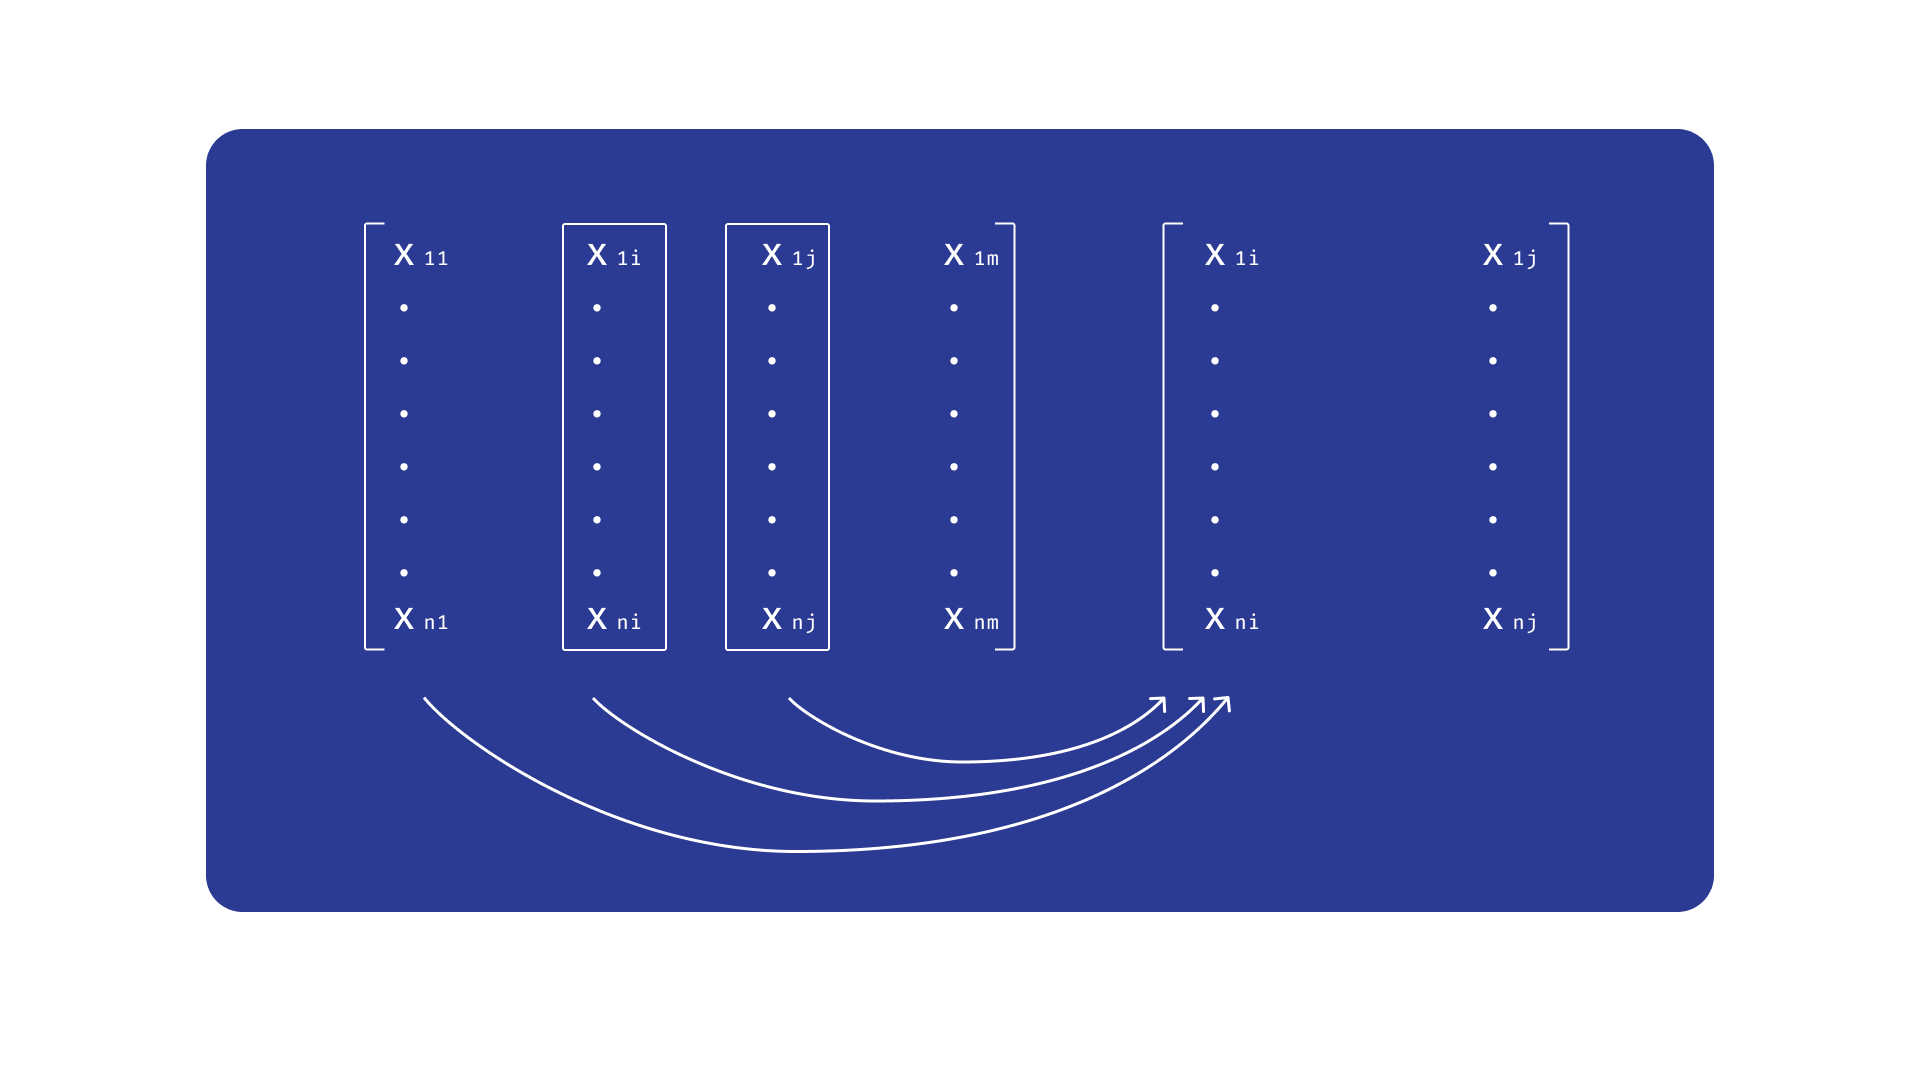


### Бэггинг
Бэггинг предполагает выбор случайных подвыборок самих объектов. Случайная подвыборка формируется с повторениями (то есть если мы выбрали некоторый объект из выборки, мы можем выбрать его еще раз. При таком подходе в подвыборку в среднем попадает около 63% объектов исходной выборки).



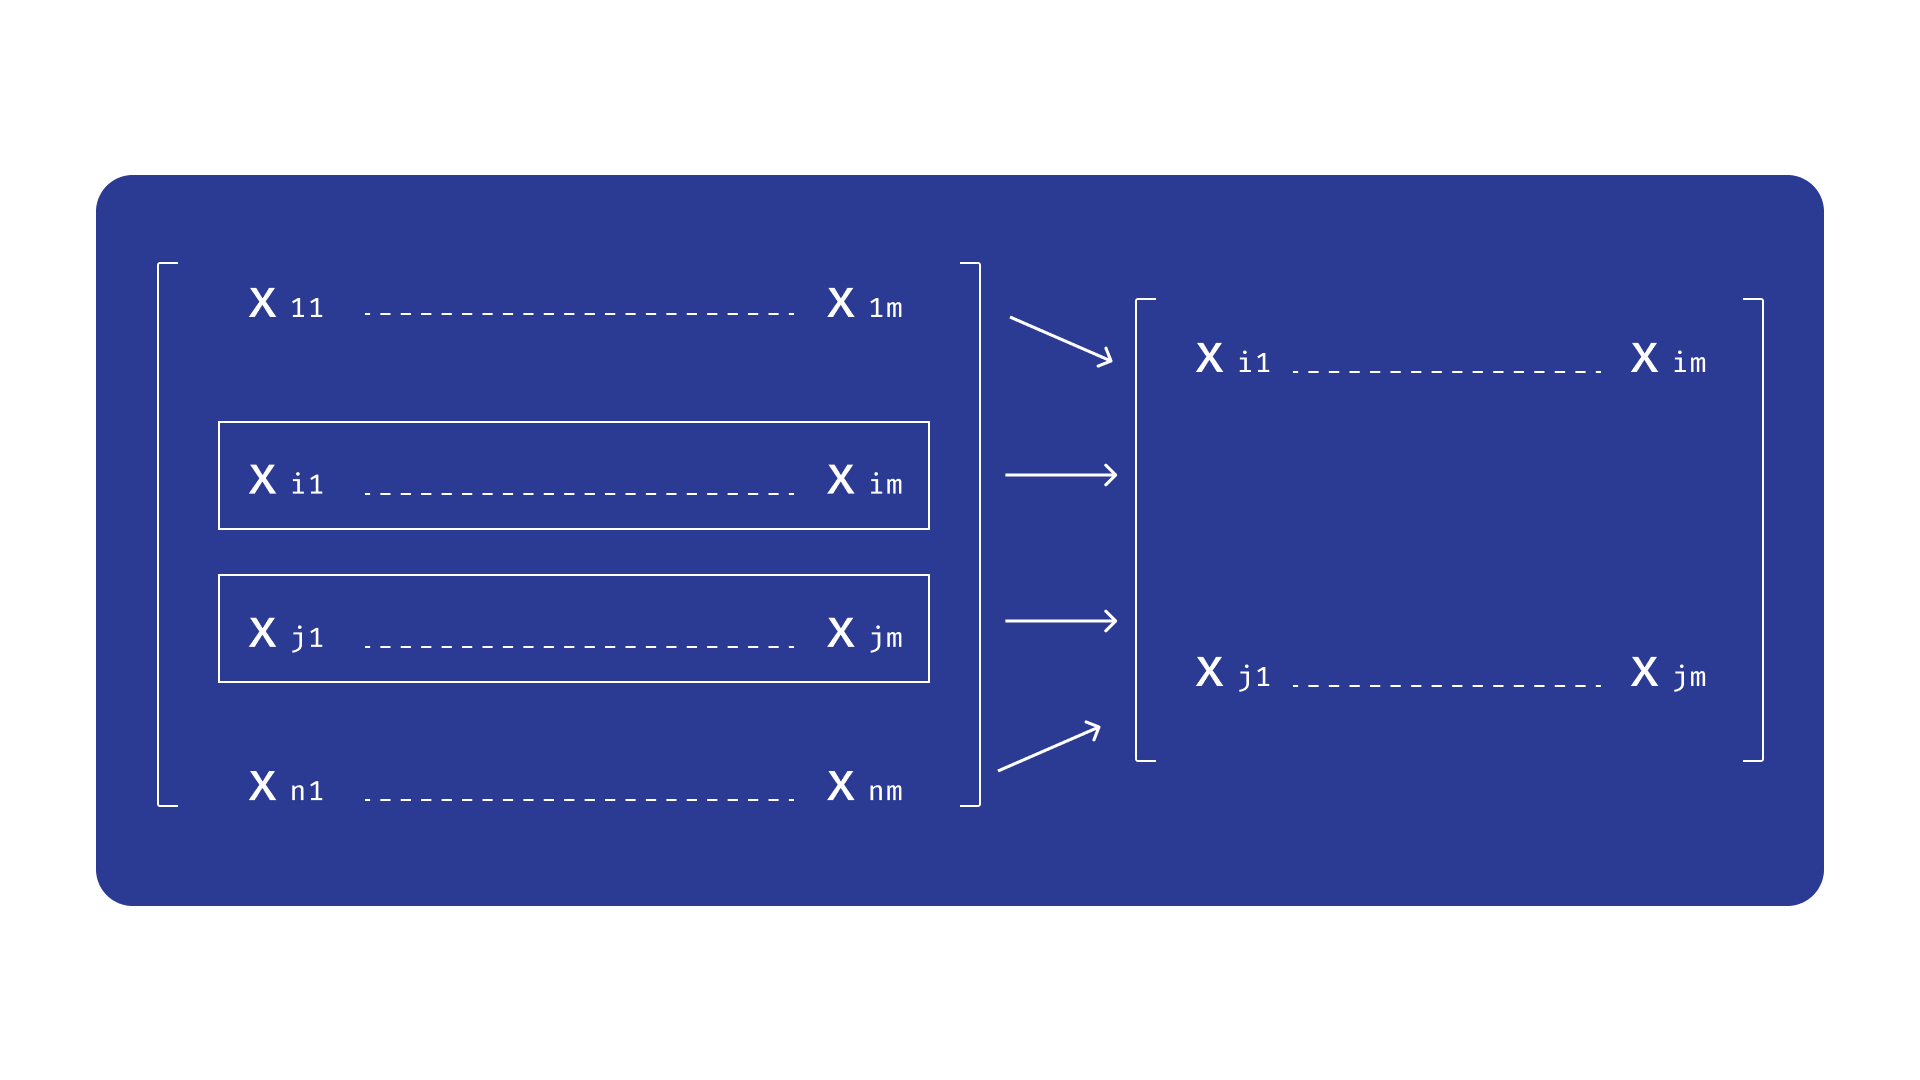


### Случайный лес
В рамках классического алгоритма случайного леса применяются оба этих подхода.


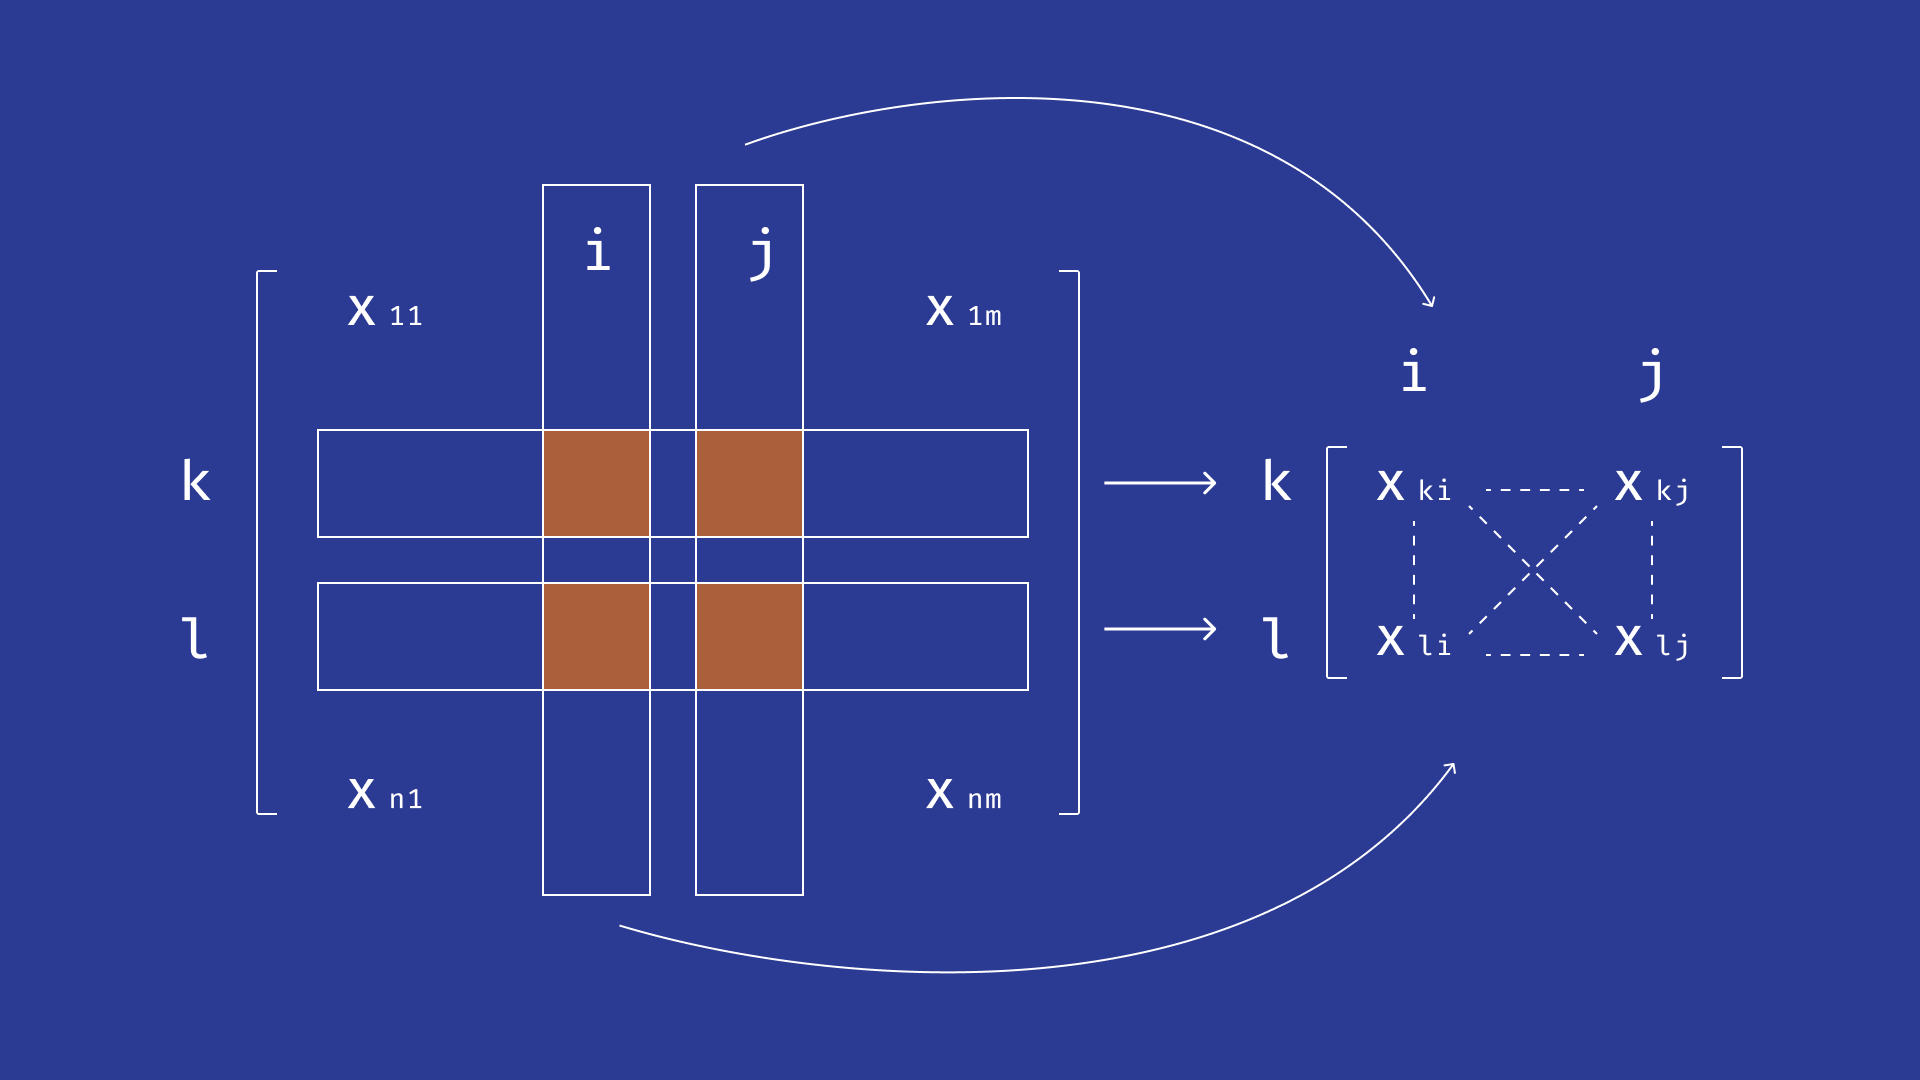

# Градиентный бустинг (англ. gradient boosting)
Фундаментально идея та же: собираем много простых моделей (деревьев), чтобы они компенсировали ошибки и случайности друг друга. Только в этом случае компенсация ошибок происходит не за счёт усреднения, а через обучение. В градиентном бустинге деревья обучаются последовательно: каждое следующее дерево строится с учётом результатов предыдущего. Вы уже знаете принцип работы градиентного спуска: когда, двигаясь в нужном направлении, последовательно на каждом следующем шаге стараются минимизировать ошибку. Идея градиентного бустинга аналогична: на определённом шаге есть модель, и она делает прогноз с какой-нибудь ошибкой. Тогда строят вторую модель, которая будет прогнозировать не исходную величину, а ошибку первой модели, и с учётом этого корректировать финальный прогноз. Третья модель спрогнозирует ошибку второй и так дальше. В финале прогнозируем конкретное наблюдение на основании всей этой последовательности. Говорим, что первая модель дала такой ответ, но к нему добавляем корректировку из второй, потом — из третьей и так, пока не дойдём до последней. Так на каждом следующем шаге (каждой следующей моделью) улучшают прогноз предыдущего. *Бустинг* означает «улучшение». А *градиентный бустинг* — «последовательное улучшение».

## Линейная композиция классификаторов

Технически градиентный бустинг строится принципиально иначе (по сравнению со случайным лесом).

Речь идет о линейной комбинации классификаторов.

Линейная комбинации - это выражение вида $$\sum\limits_{i=1}^nc_ib_i(x)$$

Вместе с тем, возможно, существует некоторое решающее правило $D$, которое определяет по этой сумме, каков же итоговый ответ (например, $D$ может быть сравнением указанной выше суммы с некоторым пороговым значением: если в сумме мы получили значение, превышающее порог, ответ 1, а иначе 0 (или -1) ).

Тогда наш ансамблевый алгоритм строится по правилу $$A(x) = D(\sum\limits_{i=1}^nc_ib_i(x))$$

Обучение такого алгоритма строится последовательно:

1. Сначала мы строим самый первый классификатор $b_1$. Здесь нет никаких хитростей, это просто самая обычная модель выбранного типа.

2. Пока мы не достигнем нужного качества, будем добавлять новые классификаторы $b_i$ к нашему ансамблю.

3. Пусть мы уже построили классификаторы $b_1 ... b_m$. Как нам добавить к ним $b_{m+1}$ ?

>Вспомним алгоритм градиентного спуска: если алгоритм $A$ параметризуется вектором параметров $\vec{w}$, то $\vec{w}_{n+1} = \vec{w}_n - α∇_wQ(x,\vec{w}) = \vec{w}_n - α\vec{g_n}$, где $α$ - это параметр, задающий размер градиентного шага.

> Наша же задача сформировать $A_{m+1} = \sum\limits_{i=1}^mc_ib_i(x) + c_{m+1}b_{m+1} = A_m + c_{m+1}b_{m+1}$
> Еще раз: $$\vec{w}_{n+1} = \vec{w}_n - α\vec{g_n}$$ и $$A_{m+1} = A_m + c_{m+1}b_{m+1}$$
> почему бы нам не строить $b_{m+1}$ так, чтобы он приближал вектор антиградиента $-\vec{g_m}$? Тогда мы получаем аналог градиентного спуска, распространенный на ансамбли.

> На человеческом языке это значит, что каждый новый классификатор мы будем строить так, чтобы он приближал ошибки предыдущего и исправлял их.


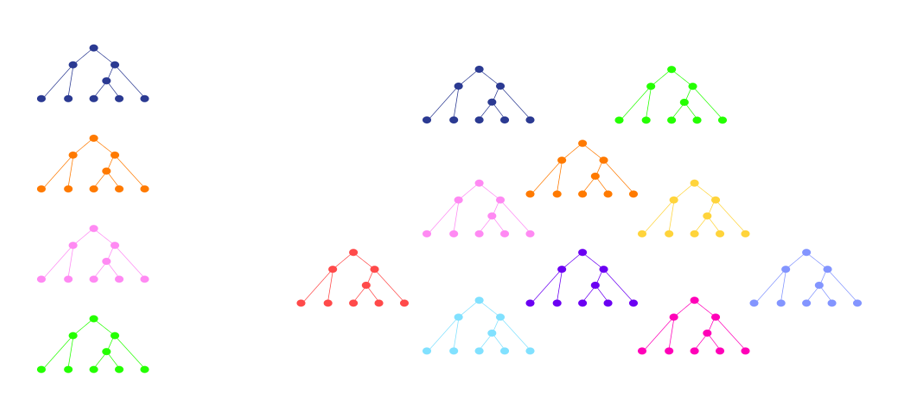

# Реализация ансамблей деревьев
Случайный лес в `sklearn` реализован в модуле `ensemble`. Из этого модуля чаще всего применяют алгоритмы `RandomForestClassifier()`и `RandomForestRegressor()` для задач классификации и регрессии, соответственно. Синтаксис объявления, обучения и прогнозирования на примере задачи классификации:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(x_test)

In [ ]:
accuracy_score(y_pred, y_test)

0.9649122807017544

Тут при объявлении модели мы задали `n_estimators` — число деревьев, на основании которых будем строить лес. При этом другие параметры дерева — например, глубину дерева `max_depth`, размер подвыборки признаков `max_features`, минимальное количество объектов в узле `min_samples_leaf` — мы не задавали и оставили их по умолчанию. На практике вы можете экспериментировать с этими значениями и смотреть, как это влияет на результат.

Градиентный бустинг в `sklearn`реализован в модуле `ensemble`. В нём алгоритмы `GradientBoostingClassifier()` и `GradientBoostingRegressor()` для задач классификации и регрессии, соответственно. Синтаксис на примере задачи классификации:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# зададим алгоритм для новой модели на основе алгоритма градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(x_test)

In [ ]:
accuracy_score(y_pred, y_test)

0.9707602339181286

# Резюме
1. Использование ансамблевых алгоритмов может существенным образом улучшить качество классификации или регрессии.
2. В качестве базовых алгоритмов необходимо использовать отличающиеся друг от друга модели.
3. Существует 2 наиболее популярных вида ансамблей - *градиентный бустинг* и *случайный лес*. Оба реализованы на *решающих деревьях*.

# Примеры
Рассмотрим следующие примеры применения популярных ансамблевых алгоритмов:

- Задача предсказания стоимости недвижимости по описанию района на основе датасета california_housing
- Синтетическую двумерную задачу бинарной классификауции с визуализацией полученной разделяющей поверхности
- Задачу классификации изображений рукописных цифр из датасета MNIST
________________________________________________

## 1. California Housing

Датасеты типа "housing" достаточно популярны в Data Science. Тематика таких датасетов - предсказание стоимости жилья по описанию района, которое обычно немного варьируется, но имеет много общих черт в различных датасетах такого типа. К таким датасетам относятся популярные датасеты Boston Housing, Kentucky Housing, Melburn Housing и т.п. Такие компании, как Циан или Авито разработали свои продукты во многом на основе именно таких датасетов.

Мы же в данном примере рассмотрим датасет California Housing.
Приведём его оригинальное описание.
____________________________________________________


California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

An household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surpinsingly large values for block groups with few households
and many empty houses, such as vacation resorts.

It can be downloaded/loaded using the
:func:`sklearn.datasets.fetch_california_housing` function.

.. topic:: References

    - Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
      Statistics and Probability Letters, 33 (1997) 291-297

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X, y = housing.data, housing.target
X_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)
X.shape

(20640, 8)

Для решения этой задачи воспользуемся моделью регрессии на основе градиентного бустинга. Выберем популярную реализацию градиентного бустинга из библиотеки `xgboost`

________________________
**Справка**
--------------
На текущий момент существует множество различных имплементаций алгоритма градиентного бустинга. Среди них можно выделить три наиболее популярные реализации:

* `XGBoost` - библиотека 2014 года, разработанная Тяньци Ченом и исследовательской группой DMLC. Изначально разработан в рамках решения соревнования  Higgs Machine Learning Challenge, где этот алгоритм показал чрезвычайную эффективность, заняв первое место. После этого сообщество заинтересовалось `xgboost`, а его имплементации были реализованы для таких языков программирования, как Python, R, Java, Scala, Julia, Perl и др. (https://xgboost.ai/)
* `Catboost` - проект 2017 года. Исчерпывающее описание `catboost` предлагает Википедия:

*Открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга. Основное API для работы с библиотекой реализовано для языка Python, также существует реализация для языка программирования R* (c)Wikipedia

* `Lightgbm` - проект 2016 года, разработанный компанией *Microsoft*. По сравнению с двумя приведёнными выше фреймворками, несколько сложен в использовании, хотя некоторые специалисты отмечают его особенную эффективность.

Наиболее популярным выбором "по умолчанию" на сегодняшний день, пожалуй, является именно `xgboost`. В общем и целом, выбор конкретного фреймворка - это дело вкуса.
_____________________

Тройка основных гиперпараметров алгоритма градиентного бустинга - это:
* n_estimators (число деревьев в ансамбле)
* max_depth (**максимальная** глубина каждого из деревьев в ансамбле)
* learning_rate (см. Лекция 3, градиентный спуск)

Интерфейс `xgboost` стандартизирован, то есть очень похож на интерфейс `sklearn`. Обучение моделей также производится при помощи вызова функции `.fit(X,y)`, а предсказание - при помощи функции `.predict(X)` или же `.predict_proba(X)`

In [ ]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

xgb_reg = XGBRegressor(n_estimators=10, max_depth=5, learning_rate=0.4)

In [ ]:
xgb_reg.fit(X_train, y_train)
preds = xgb_reg.predict(x_test)

r2 = r2_score(y_test, preds)

In [ ]:
r2

0.777403998271669

Для сравнения построим одно бинарное дерево:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)
preds_tree = reg.predict(x_test)

r2_score(y_test, preds_tree)

0.6029986793705844

Изобразим полученный результат в координатах предсказание-таргет

Text(0, 0.5, 'Метка')

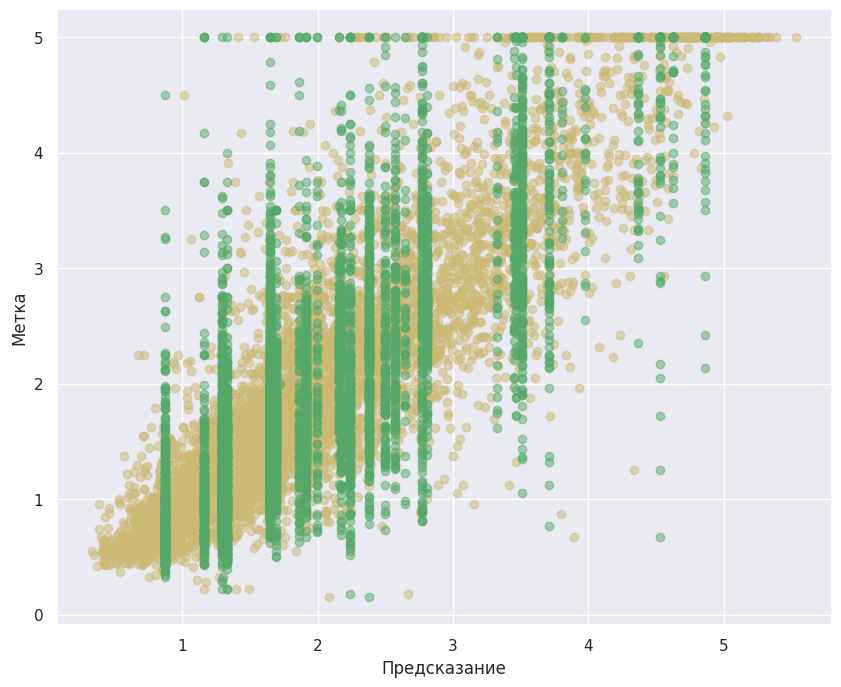

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=(10, 8))
plt.scatter(preds, y_test, label="Grad Boosting", c="y", alpha=0.5)
plt.scatter(preds_tree, y_test, label="Tree", c="g", alpha=0.5)
plt.xlabel("Предсказание")
plt.ylabel("Метка")

На этой визуализации хорошо заметно, что решающее дерево способно давать лишь один прогноз из определенного дискретного набора, в то время, как градиентный бустинг даёт непрерывный результат. Еще лучше это будет заметно, если уменьшить значение max_depth

Для лучшего понимания ситуации можем вывести гистограмму распределения ошибки предсказания

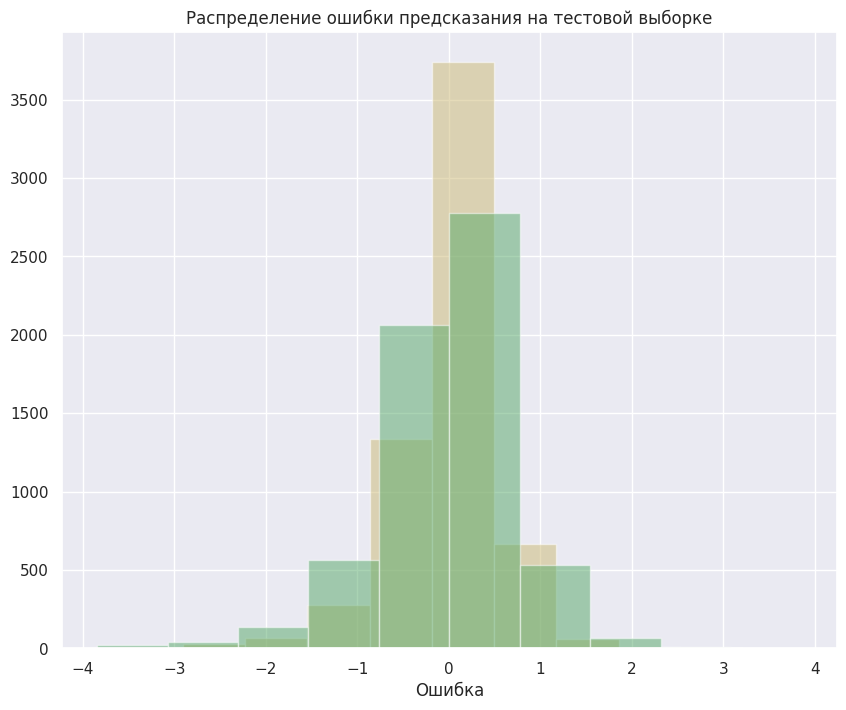

In [ ]:
ae = preds - y_test
ae_tree = preds_tree - y_test
plt.figure(figsize=(10,8))
plt.title('Распределение ошибки предсказания на тестовой выборке')
plt.xlabel('Ошибка')
h = plt.hist(ae, alpha=0.5, color='y')
h = plt.hist(ae_tree, alpha=0.5, color='g')

In [ ]:
(ae**2).mean()

0.2921661801074385

In [ ]:
(ae_tree**2).mean()

0.5210801561811792

In [ ]:
ae.std()

0.5405239086381965

In [ ]:
ae_tree.std()

0.7218491942877675

Видно также, что дисперсия ошибки предсказания решающего дерева выше, чем у ансамбля, среднеквадратичная ошибка также лучше у градиентного бустинга. В целом, оба алгоритма показали себя на достаточно высоком уровне.

## 2. Random Forest для решения задачи бинарной классификации

Рассмотрим теперь пример применения случайного леса. Основная задача этого примера - продемонстрировать типичный вид разделяющей классы поверхности, формируемой этим алгоритмом.

Алгоритм случайного леса возьмём из модуля `sklearn.ensemble`. Для задачи классификации воспользуемся классом `RandomForestClassifier` указанного модуля.

In [ ]:
# Добавляем точки на плоскости первого класса
np.seed = 10
train_data = np.random.normal(size=(50, 2))
train_data = np.r_[train_data, np.random.normal(size=(50, 2), loc=0.5, scale=2)]
train_labels = np.zeros(100)

# Добавляем точки второго класса
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=4, scale=2)]
train_labels = np.r_[train_labels, np.ones(100)]

CPU times: user 14.5 s, sys: 1.13 s, total: 15.6 s
Wall time: 16.1 s


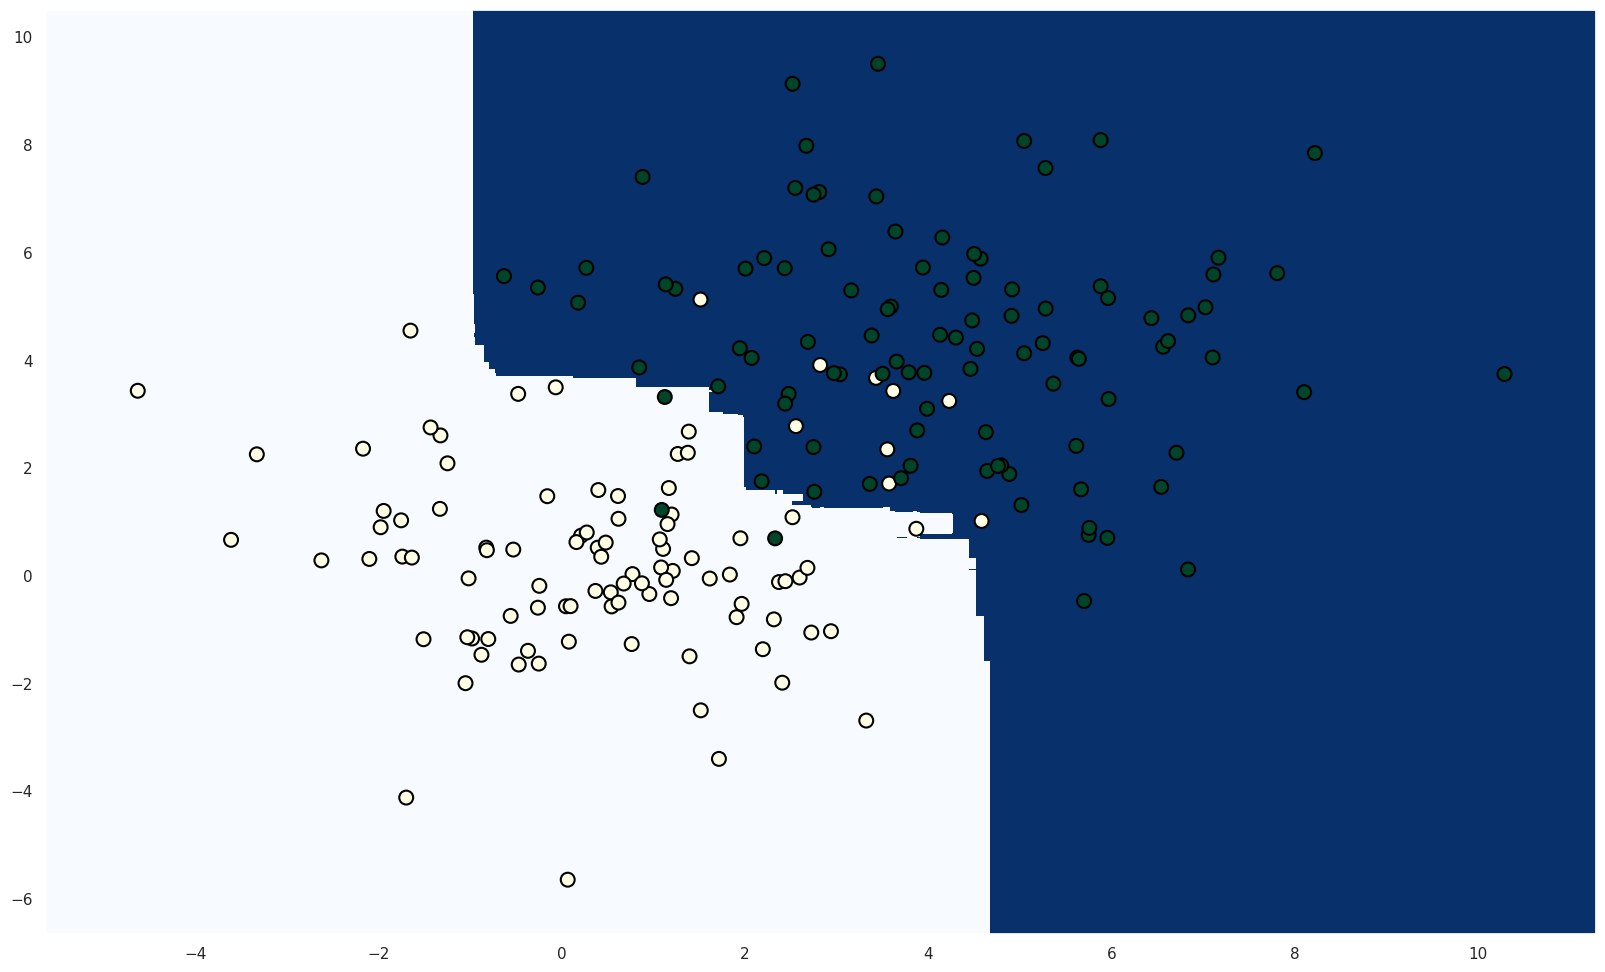

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Обучение алгоритма
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3)
rf_model.fit(train_data, train_labels)

# Разделяющая поверхность
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


xx, yy = get_grid(train_data)
predicted = rf_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(20, 12))
plt.pcolormesh(xx, yy, predicted, cmap="Blues")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="YlGn",
    edgecolors="black",
    linewidth=1.5,
);

## 3. MNIST

`MNIST` - один из самых популярных датасетов Computer Vision. В этом датасете содержится набор изображений рукописных цифр, представленных в виде массивов размерности $28 × 28$. Каждый элемент этого массива представляет из себя описание пикселя в виде значения интенсивности его цвета. Эти матрицы разворачиваются в соответствующие векторы размерности 784, таким образом, получается векторное описание каждой картинки. На этих векторах и обучается алгоритм многоклассовой классификации.

Ради разнообразия воспользуемся на этот раз реализацией градиентного бустинга из библиотеки `sklearn`. Аргумент `verbose` позволяет настроить вывод статистической информации в процессе построения деревьев.

In [ ]:
import pandas as pd

mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv")
mnist_test = pd.read_csv("./sample_data/mnist_test.csv")

X_train = mnist_train.values[:, 1:]
X_test = mnist_test.values[:, 1:]

y_train = mnist_train.values[:, 0]
y_test = mnist_test.values[:, 0]

In [ ]:
X_train.shape

(19999, 784)

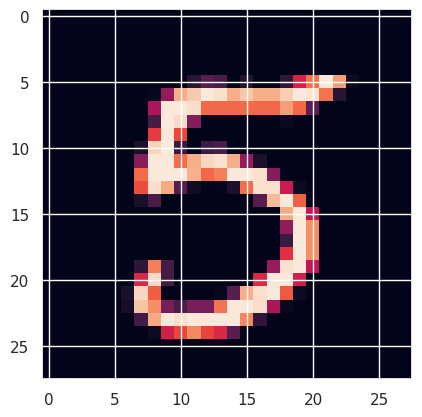

In [ ]:
plt.imshow(X_train[0].reshape(28, 28))

In [ ]:
y_train[0]

5

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=40, verbose=True, random_state=42)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.9039            5.09m
         2           1.6729            5.26m
         3           1.5025            5.23m
         4           1.3616            5.00m
         5           1.2474            4.94m
         6           1.1497            5.02m
         7           1.0638            4.82m
         8           0.9901            4.69m
         9           0.9228            4.48m
        10           0.8635            4.35m
        20           0.5284            2.94m
        30           0.3780            1.47m
        40           0.2938            0.00s


GradientBoostingClassifier(n_estimators=40, random_state=42, verbose=True)

Для задачи классификации доступна опция использования метода `.staged_decision_function(X)`, возвращающего вероятности принадлежности объектов из выборки $X$ каждому из возможных классов согласно каждой из последовательно построенных версий алгоритма (т.е. что-то вроде сечения по $i$-му дереву).

Эта функция возвращает объект типа генератор. Преобразуем его к типу `np.array`

In [ ]:
import numpy as np

array_type_train = np.array(list(clf.staged_decision_function(X_train)))
array_type_test = np.array(list(clf.staged_decision_function(X_test)))

sdf1 = np.argmax(array_type_train, axis=-1)
sdf2 = np.argmax(array_type_test, axis=-1)
"""
sdf1 = np.argmax(np.array([stage for stage in clf.staged_decision_function(X_train)]), axis=-1)
sdf2 = np.argmax(np.array([stage for stage in clf.staged_decision_function(X_test )]), axis=-1)
"""

'\nsdf1 = np.argmax(np.array([stage for stage in clf.staged_decision_function(X_train)]), axis=-1)\nsdf2 = np.argmax(np.array([stage for stage in clf.staged_decision_function(X_test )]), axis=-1)\n'

In [ ]:
sdf1.shape

(40, 19999)

Посчитаем значение метрики качества на каждой итерации построения ансамблевого алгоритма и изобразим полученный график.

In [ ]:
from sklearn.metrics import accuracy_score

train_accuracy = [accuracy_score(sdf1[i], y_train) for i in range(40)]
test_accuracy = [accuracy_score(sdf2[i], y_test) for i in range(40)]

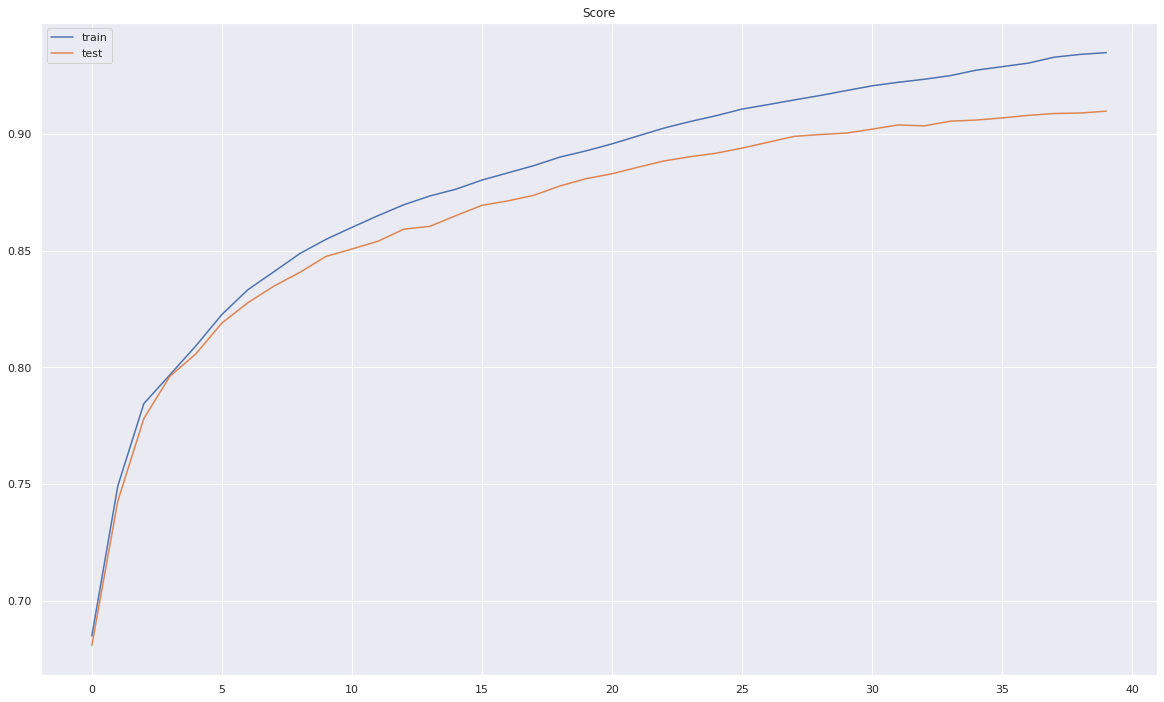

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize = (20,12))
plt.title('Score')

plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')

plt.legend()

Мы наблюдаем растущее отклонение графика качества на тренировочной выборке от качества на тестовой. Это наводит нас на мысль о возможном переобучении модели. Поговорим подробнее о переобучении.

## Переобучение

При помощи таких визуализаций можно отследить возникающий при переусложнении моделей эффект переобучения. Обнаружить его можно по расхождению графиков ошибки на тренировочной и тестовой выборках.

Для иллюстрации этого эффекта специально выберем маленькую тренировочную и большую тестовую выборки.

In [ ]:
X = mnist_train.values[:, 1:]
y = mnist_train.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, shuffle=True, random_state=42
)
clf = GradientBoostingClassifier(n_estimators=50, max_depth=15, verbose=True)

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.4771            7.19m
         2           1.1289            7.50m
         3           0.8995            7.58m
         4           0.7285            7.49m
         5           0.5975            7.40m
         6           0.4936            7.25m
         7           0.4096            7.08m
         8           0.3417            6.92m
         9           0.2838            6.72m
        10           0.2360            6.52m
        20           0.0394            4.70m
        30           0.0066            3.08m
        40           0.0011            1.53m
        50           0.0002            0.00s


GradientBoostingClassifier(max_depth=15, n_estimators=50, verbose=True)

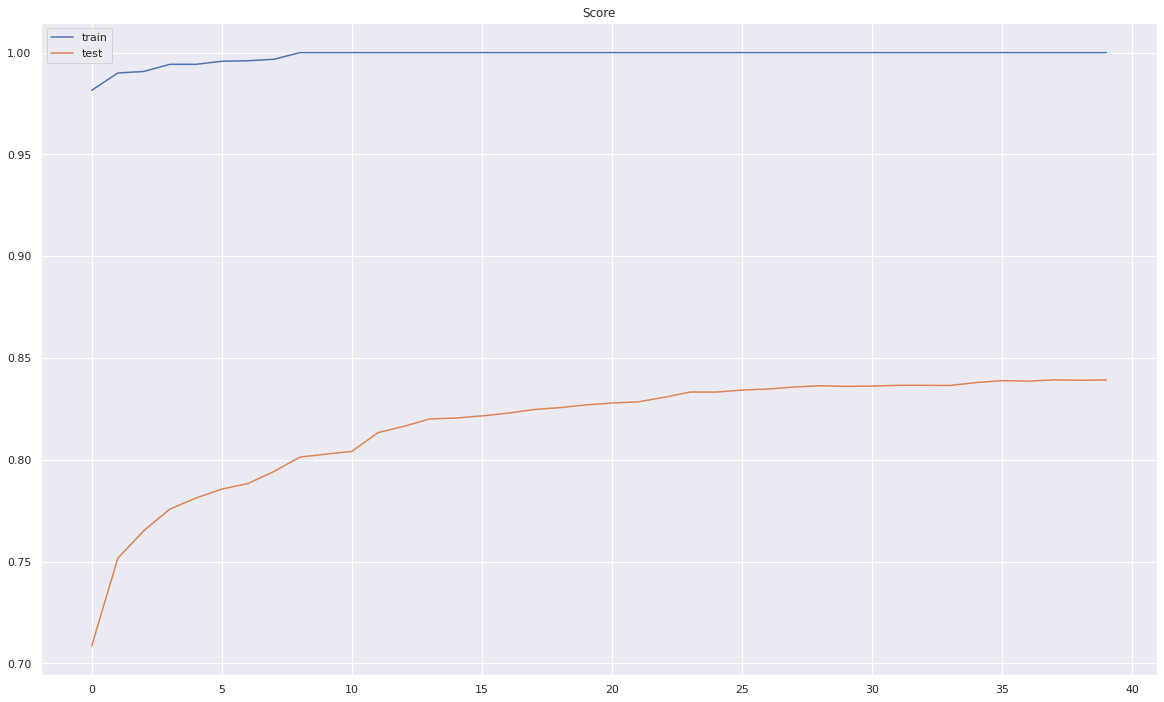

In [ ]:
array_type_train = np.array(list(clf.staged_decision_function(X_train)))
array_type_test = np.array(list(clf.staged_decision_function(X_test)))

sdf1 = np.argmax(array_type_train, axis=-1)
sdf2 = np.argmax(array_type_test, axis=-1)

train_accuracy = [accuracy_score(sdf1[i], y_train) for i in range(40)]
test_accuracy = [accuracy_score(sdf2[i], y_test) for i in range(40)]

plt.figure(figsize=(20, 12))
plt.title("Score")

plt.plot(train_accuracy, label="train")
plt.plot(test_accuracy, label="test")

plt.legend()

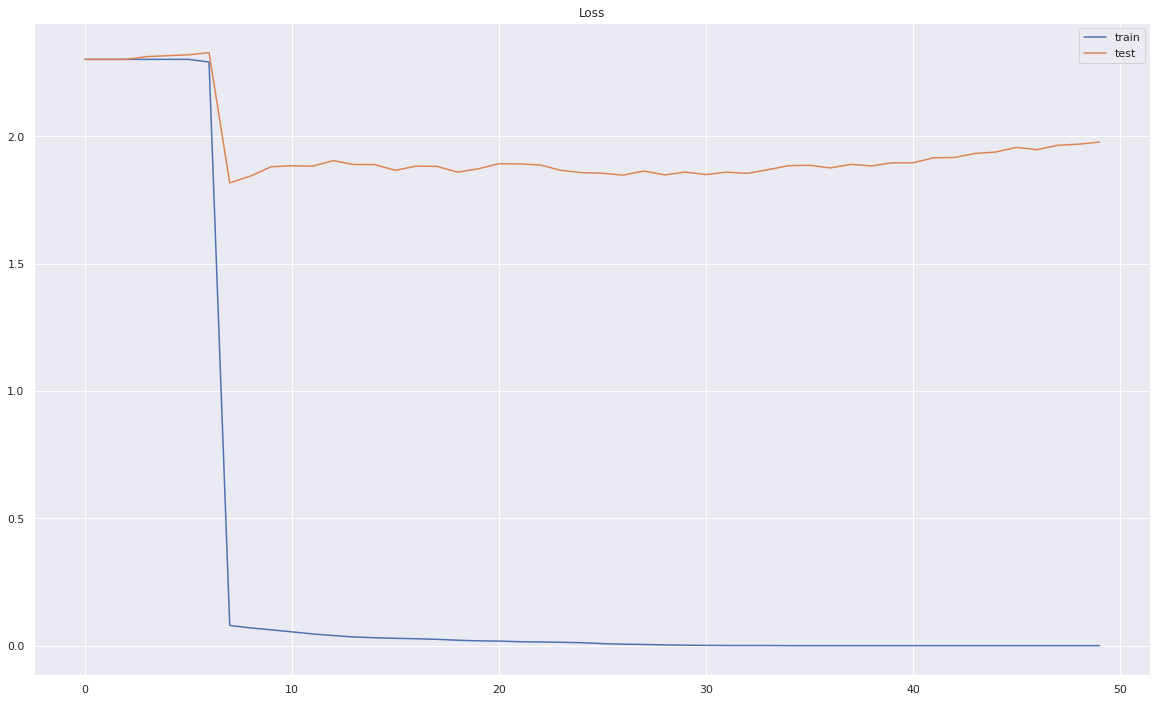

In [ ]:
from sklearn.metrics import log_loss

test_loss = [
    log_loss(y_test, array_type_test[i], labels=np.arange(10)) for i in range(len(sdf2))
]
train_loss = [
    log_loss(y_train, array_type_train[i], labels=np.arange(10))
    for i in range(len(sdf1))
]

plt.figure(figsize=(20, 12))
plt.title("Loss")

plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")

plt.legend()

В данном случае эффект переобучения очень явно выражен в резком расхождении графиков loss-функции на тренировочной и тестовой выборках. Таким образом, можно обнаружить оптимальное количество деревьев в ансамбле при фиксированных остальных гиперпараметрах.